In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn as adeq

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy as spy

tf.keras.backend.set_floatx('float32')

## Define some useful classes

### Initial conditions

In [4]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

## Main part starts here

## Solve for high-resolution

In [5]:
app = adeq.ad_eqn_args(T = 2.5, nt = 250, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x = tf.linspace(0., app.L, app.nx)
u0 = initial_cond(x, app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

op = adeq.operators(app)

u = ddeinttf(adeq.ad_eqn(op), u0, t)

## Solve for low resolution

In [6]:
app_lowres = adeq.ad_eqn_args(T = 2.5, nt = 250, L = 1., nx = 25, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x_lowres = tf.linspace(0., app_lowres.L, app_lowres.nx)
u0_lowres = initial_cond(x_lowres, app_lowres) # Initial conditions
t_lowres = tf.linspace(0., app_lowres.T, app_lowres.nt) # Time array

op_lowres = adeq.operators(app_lowres)

u_lowres = ddeinttf(adeq.ad_eqn(op_lowres), u0_lowres, t_lowres)

### Plot

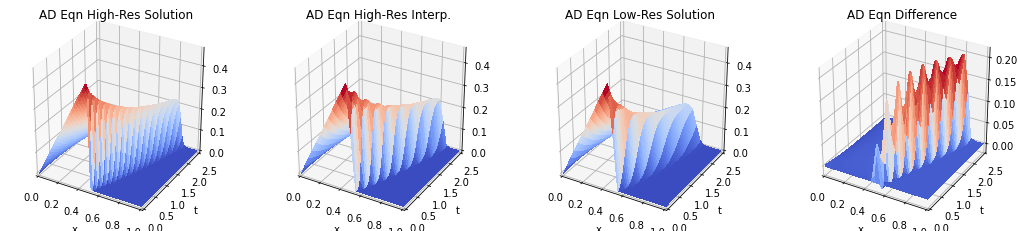

In [7]:
fig = plt.figure(figsize=(18, 4), facecolor='white')
ax_u = fig.add_subplot(141, projection='3d')
ax_u_high_interp_low = fig.add_subplot(142, projection='3d')
ax_u_lowres = fig.add_subplot(143, projection='3d')
ax_u_diff = fig.add_subplot(144, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('AD Eqn High-Res Solution')
ax_u.set_xlabel('x')
ax_u.set_ylabel('t')
ax_u.plot_surface(X, T, tf.squeeze(u, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])

X_lowres, T_lowres = np.meshgrid(x_lowres.numpy(), t_lowres.numpy())

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_high_interp_low.cla()
ax_u_high_interp_low.set_title('AD Eqn High-Res Interp.')
ax_u_high_interp_low.set_xlabel('x')
ax_u_high_interp_low.set_ylabel('t')
ax_u_high_interp_low.plot_surface(X_lowres, T_lowres, f(x_lowres, t_lowres), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u_high_interp_low.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_high_interp_low.set_ylim(t_lowres[0], t_lowres[-1])

fig.show()

ax_u_lowres.cla()
ax_u_lowres.set_title('AD Eqn Low-Res Solution')
ax_u_lowres.set_xlabel('x')
ax_u_lowres.set_ylabel('t')
ax_u_lowres.plot_surface(X_lowres, T_lowres, tf.squeeze(u_lowres, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u_lowres.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_lowres.set_ylim(t_lowres[0], t_lowres[-1])

ax_u_diff.cla()
ax_u_diff.set_title('AD Eqn Difference')
ax_u_diff.set_xlabel('x')
ax_u_diff.set_ylabel('t')
ax_u_diff.plot_surface(X_lowres, T_lowres, f(x_lowres, t_lowres) - tf.squeeze(u_lowres, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u_diff.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_diff.set_ylim(t_lowres[0], t_lowres[-1])

fig.show()